# **BBM479-480 Final Project**<br>
## **Anomaly Detection on Car Crashes**<br><br>

**Alperen Tastekin 21727757**<br>
**Berk Karaimer 21827541**<br>


In [1]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN,BatchNormalization,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
def loadDatasetAndLabels(datasetFilePath,labelFilePath,includeYOLOFlag):
  dataset = np.load(datasetFilePath,allow_pickle = True)
  dataset = dataset[dataset.files[0]]
  labels = np.load(labelFilePath,allow_pickle = True)
  labels = labels[labels.files[0]]
  if(includeYOLOFlag):
    dataset = dataset.reshape(70000,5,4099)
    part1 = labels[:30000]
    part2 = labels[45000:85000]
    labels = np.concatenate((part1,part2),axis = 0)
    return dataset,labels
  dataset = dataset.reshape(90000,5,4096)
  return dataset,labels

In [4]:
def findAndDropNA(dataset,labels):
  indexOfNA = []
  np.argwhere(np.isnan(dataset))
  for i in np.argwhere(np.isnan(dataset)):
    if(i[0] not in indexOfNA):
      indexOfNA.append(i[0])  
  #print("Found ",len(indexOfNA)," NA elements")
  '''
  for i in indexOfNA:
    zeroArray = np.zeros((5,4099),dtype = int)
    zeroArray = zeroArray.astype('float64')
    dataset[i] = zeroArray
  '''
  dataset = np.delete(dataset,indexOfNA,0)
  labels = np.delete(labels,indexOfNA,0)
  
  return dataset,labels

In [5]:
def normalizeDataset(dataset,includeYOLOFlag):
  normalizedDataset = dataset
  for i in normalizedDataset:
    i=i.flatten()
    i = preprocessing.normalize([i])
    if(includeYOLOFlag):
      i=i.reshape((5,4099))
    else:
      i=i.reshape((5,4096))
  return normalizedDataset

In [6]:
def binaryPredictions(model,testData):
  predictions= model.predict(testData)
  predictions = predictions.flatten()
  for i in range(len(predictions)):
    if(predictions[i]<=0.5):
      predictions[i]=0
    else:
      predictions[i]=1
  predictions = np.array(predictions,dtype=int)
  return predictions
  

In [7]:
def visualizeTrainResults(trainHistory):
  plt.plot(trainHistory.history['accuracy'])
  plt.plot(trainHistory.history['val_accuracy'])
  plt.title('Model Train Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(trainHistory.history['loss'])
  plt.plot(trainHistory.history['val_loss'])
  plt.title('Model Train Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## Dataset Without YOLO and Magnitude Optical Flow

In [9]:
dataset , labels = loadDatasetAndLabels("/content/drive/My Drive/CarCrashDatasetWithOpticalFlowAndYOLO/DatasetWithoutYOLO_M/FINALDATASET_LAST.npz","/content/drive/My Drive/finalLabels.npz",False)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (90000, 5, 4096)
Labels Shape: (90000,)


In [10]:
dataset , labels = findAndDropNA(dataset,labels)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (89943, 5, 4096)
Labels Shape: (89943,)


In [11]:
dataset = normalizeDataset(dataset,False)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)
del dataset
del labels

In [13]:
print("Train Size",X_train.shape)
print("Test Size",X_test.shape)
print("Train Label Size",y_train.shape)
print("Test Label Size",y_test.shape)

Train Size (62960, 5, 4096)
Test Size (26983, 5, 4096)
Train Label Size (62960,)
Test Label Size (26983,)


In [8]:

regressor = Sequential()

regressor.add(LSTM(units = 16,activation='relu', return_sequences = True,input_shape = (5, 4096),dropout=0.2))
regressor.add(BatchNormalization())
 

regressor.add(LSTM(units = 8,activation='relu', return_sequences = True))

regressor.add(LSTM(units = 4))

regressor.add(Dense(units = 1,activation='sigmoid'))

opt = keras.optimizers.SGD(learning_rate=0.00001)

regressor.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])



In [18]:
trainHistory = regressor.fit(x = X_train , y = y_train, batch_size=64,epochs=24,shuffle=True,validation_split=0.3)
regressor.save("/content/drive/My Drive/bestModelWithoutYOLO_M")

Epoch 1/24
689/689 [==============================] - 17s 25ms/step - loss: 0.7003 - accuracy: 0.4612 - val_loss: 0.7057 - val_accuracy: 0.2781
Epoch 2/24
689/689 [==============================] - 17s 25ms/step - loss: 0.6983 - accuracy: 0.4848 - val_loss: 0.7018 - val_accuracy: 0.2903
Epoch 3/24
689/689 [==============================] - 17s 25ms/step - loss: 0.6966 - accuracy: 0.5100 - val_loss: 0.6980 - val_accuracy: 0.4515
Epoch 4/24
689/689 [==============================] - 17s 25ms/step - loss: 0.6946 - accuracy: 0.5294 - val_loss: 0.6957 - val_accuracy: 0.5092
Epoch 5/24
689/689 [==============================] - 17s 25ms/step - loss: 0.6927 - accuracy: 0.5516 - val_loss: 0.6926 - val_accuracy: 0.5442
Epoch 6/24
689/689 [==============================] - 18s 26ms/step - loss: 0.6909 - accuracy: 0.5749 - val_loss: 0.6900 - val_accuracy: 0.5717
Epoch 7/24
689/689 [==============================] - 17s 25ms/step - loss: 0.6893 - accuracy: 0.5932 - val_loss: 0.6883 - val_accuracy:

INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithoutYOLO_M/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithoutYOLO_M/assets


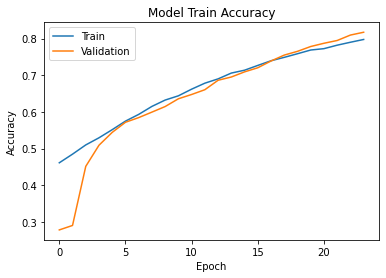

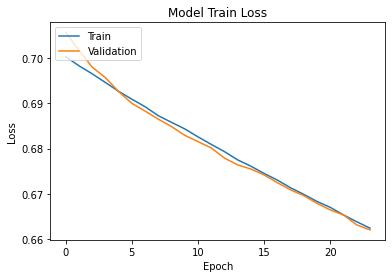

In [19]:
visualizeTrainResults(trainHistory)

In [20]:
model = keras.models.load_model('/content/drive/My Drive/bestModelWithoutYOLO_M')

In [21]:
predictions= binaryPredictions(model,X_test)

In [22]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Positive : ",tp)
print("False Positive : ",fp)
print("False Negative : ",fn)
print("True Negative : ",tn)

True Positive :  474
False Positive :  2604
False Negative :  2280
True Negative :  21625


In [25]:
truePositiveRate = tp/(tp+fn)
accuracyRate = (tp+tn) / (tp+tn+fp+fn)
misclassificationRate = (fp+fn) / (fp+fn+tp+tn)
trueNegativeRate = tn / (tn+fp)
f1 = f1_score(y_test, predictions, average='weighted') 

print("Accuracy Rate : ",accuracyRate)
print("True Positive Rate : ",truePositiveRate)
print("Error Rate : ",misclassificationRate)
print("True Negative Rate : ",trueNegativeRate)
print("F1 Score: ", f1)

Accuracy Rate :  0.8189971463514064
True Positive Rate :  0.1721132897603486
Error Rate :  0.18100285364859356
True Negative Rate :  0.8925254859878657
F1 Score:  0.8234158194047823


## Dataset Without YOLO and Orientation Optical Flow

In [8]:
dataset , labels = loadDatasetAndLabels("/content/drive/My Drive/CarCrashDatasetWithOpticalFlowAndYOLO/DatasetWithoutYOLO_O/FINALDATASET_LAST.npz","/content/drive/My Drive/finalLabels.npz",False)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (90000, 5, 4096)
Labels Shape: (90000,)


In [9]:
dataset , labels = findAndDropNA(dataset,labels)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (90000, 5, 4096)
Labels Shape: (90000,)


In [11]:
dataset = normalizeDataset(dataset,False)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)
del dataset
del labels

In [13]:
print("Train Size",X_train.shape)
print("Test Size",X_test.shape)
print("Train Label Size",y_train.shape)
print("Test Label Size",y_test.shape)

Train Size (63000, 5, 4096)
Test Size (27000, 5, 4096)
Train Label Size (63000,)
Test Label Size (27000,)


In [14]:
trainHistory = regressor.fit(x = X_train , y = y_train, batch_size=64,epochs=24,shuffle=True,validation_split=0.3)
regressor.save("/content/drive/My Drive/bestModelWithoutYOLO_O")

Epoch 1/24
690/690 [==============================] - 20s 24ms/step - loss: 0.6791 - accuracy: 0.6553 - val_loss: 0.6847 - val_accuracy: 0.6347
Epoch 2/24
690/690 [==============================] - 15s 22ms/step - loss: 0.6768 - accuracy: 0.6772 - val_loss: 0.6838 - val_accuracy: 0.6441
Epoch 3/24
690/690 [==============================] - 15s 22ms/step - loss: 0.6739 - accuracy: 0.7031 - val_loss: 0.6818 - val_accuracy: 0.6812
Epoch 4/24
690/690 [==============================] - 15s 22ms/step - loss: 0.6716 - accuracy: 0.7248 - val_loss: 0.6790 - val_accuracy: 0.7302
Epoch 5/24
690/690 [==============================] - 15s 22ms/step - loss: 0.6688 - accuracy: 0.7460 - val_loss: 0.6769 - val_accuracy: 0.7604
Epoch 6/24
690/690 [==============================] - 15s 22ms/step - loss: 0.6663 - accuracy: 0.7639 - val_loss: 0.6740 - val_accuracy: 0.8026
Epoch 7/24
690/690 [==============================] - 15s 22ms/step - loss: 0.6637 - accuracy: 0.7801 - val_loss: 0.6709 - val_accuracy:

INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithoutYOLO_O/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithoutYOLO_O/assets


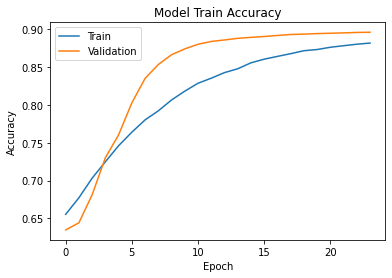

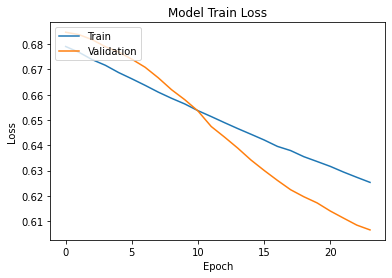

In [15]:
visualizeTrainResults(trainHistory)

In [16]:
model = keras.models.load_model('/content/drive/My Drive/bestModelWithoutYOLO_O')

In [17]:
predictions= binaryPredictions(model,X_test)

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Positive : ",tp)
print("False Positive : ",fp)
print("False Negative : ",fn)
print("True Negative : ",tn)

True Positive :  21
False Positive :  74
False Negative :  2770
True Negative :  24135


In [19]:
truePositiveRate = tp/(tp+fn)
accuracyRate = (tp+tn) / (tp+tn+fp+fn)
misclassificationRate = (fp+fn) / (fp+fn+tp+tn)
trueNegativeRate = tn / (tn+fp)
f1 = f1_score(y_test, predictions, average='weighted') 

print("Accuracy Rate : ",accuracyRate)
print("True Positive Rate : ",truePositiveRate)
print("Error Rate : ",misclassificationRate)
print("True Negative Rate : ",trueNegativeRate)
print("F1 Score: ", f1)

Accuracy Rate :  0.8946666666666667
True Positive Rate :  0.007524184879971337
Error Rate :  0.10533333333333333
True Negative Rate :  0.9969432855549589
F1 Score:  0.8482452086297608


## Dataset Without YOLO and Magnitude * Orientation Optical Flow

In [9]:
dataset , labels = loadDatasetAndLabels("/content/drive/My Drive/CarCrashDatasetWithOpticalFlowAndYOLO/DatasetWithoutYOLO_MO/FINALDATASET_LAST.npz","/content/drive/My Drive/finalLabels.npz",False)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (90000, 5, 4096)
Labels Shape: (90000,)


In [10]:
dataset , labels = findAndDropNA(dataset,labels)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (89909, 5, 4096)
Labels Shape: (89909,)


In [11]:
dataset = normalizeDataset(dataset,False)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)
del dataset
del labels

In [13]:
print("Train Size",X_train.shape)
print("Test Size",X_test.shape)
print("Train Label Size",y_train.shape)
print("Test Label Size",y_test.shape)

Train Size (62936, 5, 4096)
Test Size (26973, 5, 4096)
Train Label Size (62936,)
Test Label Size (26973,)


In [14]:
trainHistory = regressor.fit(x = X_train , y = y_train, batch_size=64,epochs=24,shuffle=True,validation_split=0.3)
regressor.save("/content/drive/My Drive/bestModelWithoutYOLO_MO")

Epoch 1/24
689/689 [==============================] - 30s 27ms/step - loss: 0.6919 - accuracy: 0.5813 - val_loss: 0.6937 - val_accuracy: 0.5417
Epoch 2/24
689/689 [==============================] - 17s 24ms/step - loss: 0.6900 - accuracy: 0.6047 - val_loss: 0.6910 - val_accuracy: 0.6108
Epoch 3/24
689/689 [==============================] - 16s 24ms/step - loss: 0.6877 - accuracy: 0.6298 - val_loss: 0.6889 - val_accuracy: 0.6588
Epoch 4/24
689/689 [==============================] - 17s 24ms/step - loss: 0.6860 - accuracy: 0.6529 - val_loss: 0.6870 - val_accuracy: 0.6770
Epoch 5/24
689/689 [==============================] - 16s 24ms/step - loss: 0.6840 - accuracy: 0.6747 - val_loss: 0.6856 - val_accuracy: 0.7094
Epoch 6/24
689/689 [==============================] - 17s 24ms/step - loss: 0.6820 - accuracy: 0.6956 - val_loss: 0.6823 - val_accuracy: 0.7500
Epoch 7/24
689/689 [==============================] - 16s 24ms/step - loss: 0.6798 - accuracy: 0.7131 - val_loss: 0.6804 - val_accuracy:

INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithoutYOLO_MO/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithoutYOLO_MO/assets


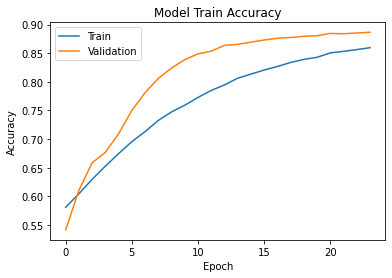

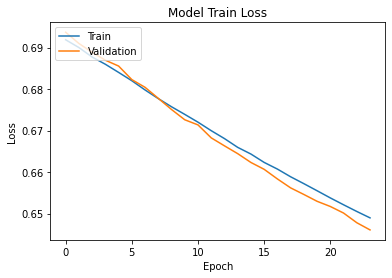

In [15]:
visualizeTrainResults(trainHistory)

In [16]:
model = keras.models.load_model('/content/drive/My Drive/bestModelWithoutYOLO_MO')

In [17]:
predictions= binaryPredictions(model,X_test)

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Positive : ",tp)
print("False Positive : ",fp)
print("False Negative : ",fn)
print("True Negative : ",tn)

True Positive :  43
False Positive :  402
False Negative :  2725
True Negative :  23803


In [19]:
truePositiveRate = tp/(tp+fn)
accuracyRate = (tp+tn) / (tp+tn+fp+fn)
misclassificationRate = (fp+fn) / (fp+fn+tp+tn)
trueNegativeRate = tn / (tn+fp)
f1 = f1_score(y_test, predictions, average='weighted') 

print("Accuracy Rate : ",accuracyRate)
print("True Positive Rate : ",truePositiveRate)
print("Error Rate : ",misclassificationRate)
print("True Negative Rate : ",trueNegativeRate)
print("F1 Score: ", f1)

Accuracy Rate :  0.8840692544396248
True Positive Rate :  0.015534682080924855
Error Rate :  0.11593074556037519
True Negative Rate :  0.9833918611857054
F1 Score:  0.8448144330946031


## Dataset WithYOLO and Magnitude * Orientation Optical Flow

In [10]:
dataset , labels = loadDatasetAndLabels("/content/drive/My Drive/CarCrashDatasetWithOpticalFlowAndYOLO/DatasetWithYOLO_MO/finaldataset_last_small.npz","/content/drive/My Drive/finalLabels.npz",True)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (70000, 5, 4099)
Labels Shape: (70000,)


In [11]:
dataset , labels = findAndDropNA(dataset,labels)
print("Dataset Shape:",dataset.shape)
print("Labels Shape:",labels.shape)

Dataset Shape: (69909, 5, 4099)
Labels Shape: (69909,)


In [12]:
dataset = normalizeDataset(dataset,True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)
del dataset
del labels

In [14]:
print("Train Size",X_train.shape)
print("Test Size",X_test.shape)
print("Train Label Size",y_train.shape)
print("Test Label Size",y_test.shape)

Train Size (48936, 5, 4099)
Test Size (20973, 5, 4099)
Train Label Size (48936,)
Test Label Size (20973,)


In [17]:
trainHistory = regressor.fit(x = X_train , y = y_train, batch_size=64,epochs=30,shuffle=True,validation_split=0.3)
regressor.save("/content/drive/My Drive/bestModelWithYOLO_MO")

Epoch 1/30
536/536 [==============================] - 32s 39ms/step - loss: 0.6915 - accuracy: 0.5746 - val_loss: 0.6881 - val_accuracy: 0.6339
Epoch 2/30
536/536 [==============================] - 18s 33ms/step - loss: 0.6895 - accuracy: 0.6078 - val_loss: 0.6847 - val_accuracy: 0.6797
Epoch 3/30
536/536 [==============================] - 18s 33ms/step - loss: 0.6876 - accuracy: 0.6328 - val_loss: 0.6824 - val_accuracy: 0.7098
Epoch 4/30
536/536 [==============================] - 18s 33ms/step - loss: 0.6856 - accuracy: 0.6631 - val_loss: 0.6805 - val_accuracy: 0.7326
Epoch 5/30
536/536 [==============================] - 18s 33ms/step - loss: 0.6838 - accuracy: 0.6844 - val_loss: 0.6791 - val_accuracy: 0.7571
Epoch 6/30
536/536 [==============================] - 18s 33ms/step - loss: 0.6821 - accuracy: 0.7050 - val_loss: 0.6772 - val_accuracy: 0.7930
Epoch 7/30
536/536 [==============================] - 18s 33ms/step - loss: 0.6804 - accuracy: 0.7262 - val_loss: 0.6767 - val_accuracy:

INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithYOLO_MO/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/bestModelWithYOLO_MO/assets


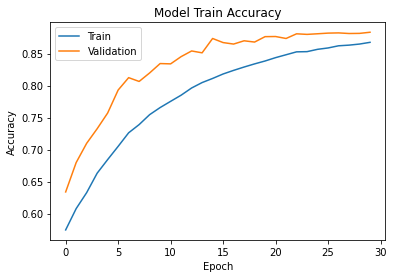

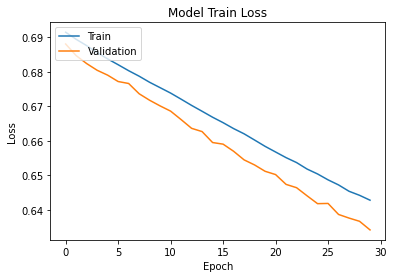

In [18]:
visualizeTrainResults(trainHistory)

In [19]:
model = keras.models.load_model('/content/drive/My Drive/bestModelWithYOLO_MO')

In [20]:
predictions= binaryPredictions(model,X_test)

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Positive : ",tp)
print("False Positive : ",fp)
print("False Negative : ",fn)
print("True Negative : ",tn)

True Positive :  13
False Positive :  198
False Negative :  2344
True Negative :  18418


In [20]:
truePositiveRate = tp/(tp+fn)
accuracyRate = (tp+tn) / (tp+tn+fp+fn)
misclassificationRate = (fp+fn) / (fp+fn+tp+tn)
trueNegativeRate = tn / (tn+fp)
f1 = f1_score(y_test, predictions, average='weighted') 

print("Accuracy Rate : ",accuracyRate)
print("True Positive Rate : ",truePositiveRate)
print("Error Rate : ",misclassificationRate)
print("True Negative Rate : ",trueNegativeRate)
print("F1 Score: ", f1)

Accuracy Rate :  0.8787965479425929
True Positive Rate :  0.005515485787017395
Error Rate :  0.12120345205740714
True Negative Rate :  0.98936399
F1 Score:  0.8314561553996861
